In [21]:
import numpy as np
from matplotlib import pylab as plt

In [22]:
# Test to show receive and re-transmit of internal dds signal
# verifies operation of readRx() and writeTx()
from pluto.pluto_sdr import PlutoSdr
sdr = PlutoSdr()
%matplotlib inline

In [23]:
# set up tx and rx on same channel and physically connect via the loop-back cable
sdr.rx_lo_freq = 430                  # frequency units are in MHz
sdr.tx_lo_freq = 430
sdr.tx_gain = -30

In [24]:
# turn on a test signal from the internal DDS
sdr.sampling_frequency = 10
sdr.ddsFrequ(0.5)                # single tone
sdr.ddsAmplitude(-10)            # amplitude in dB wrt full scale
sdr.tx_state = sdr.TX_DDS

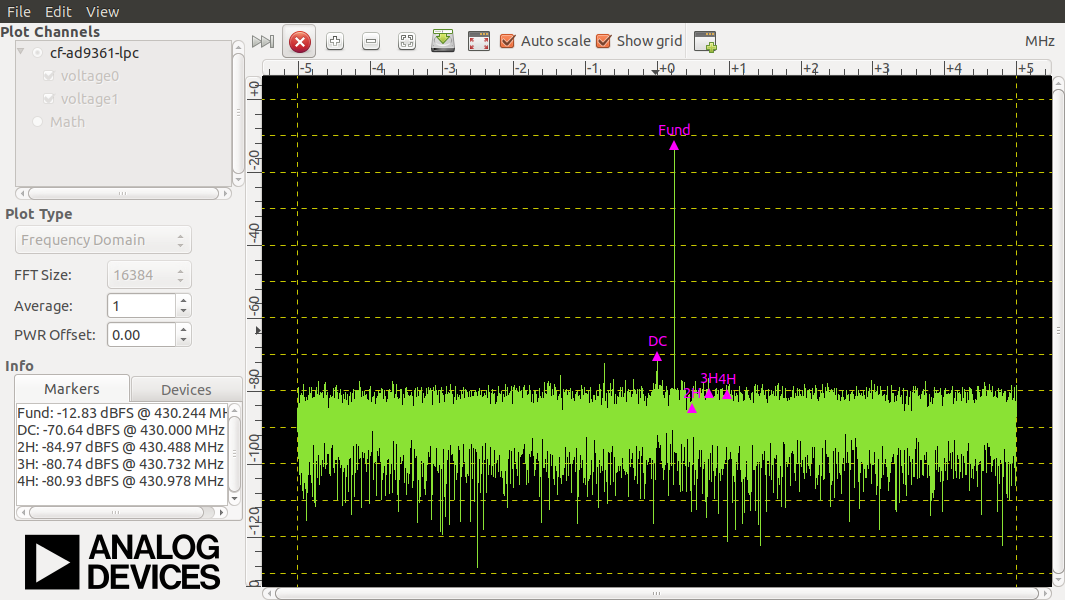

In [25]:
# show pluto output as seen via iio Scope
from IPython.display import Image
display(Image('dds_capture.png', width=800, height=800))

In [26]:
# collect data from rx
dds_data = sdr.readRx(0x4000, raw=False)

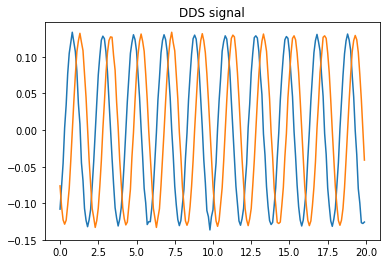

In [27]:
# data visualisation using matplotlib
# create the time axis
time = np.arange(len(dds_data))/sdr.sampling_frequency
zoom = slice(200)               # slice operator provides a sub-section of a data array
plt.title('DDS signal')
plt.plot(time[zoom], dds_data.real[zoom], time[zoom], dds_data.imag[zoom])

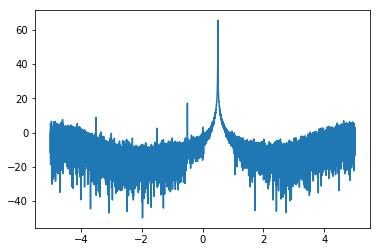

In [28]:
# frequency domain visualisation
from numpy.fft import fft, fftfreq, fftshift
fr_x = fftshift(fftfreq(len(dds_data), 1/sdr.sampling_frequency))
F_x = fftshift(fft(dds_data))
plt.plot(fr_x, 20*np.log10(np.abs(F_x)))

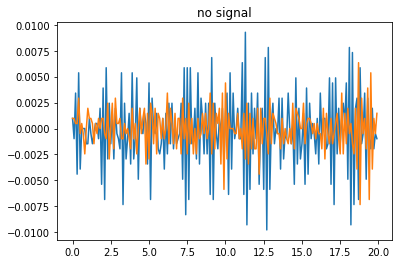

In [29]:
# turn DDS off then re-transmit using captured data
sdr.tx_state = sdr.TX_OFF
off_data = sdr.readRx(0x4000, raw=False)
plt.title('no signal')
plt.plot(time[zoom], off_data.real[zoom], time[zoom], off_data.imag[zoom])

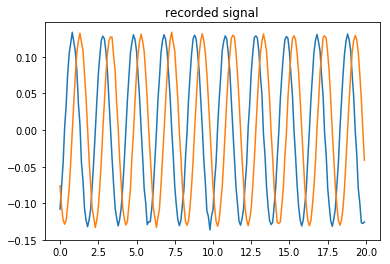

In [30]:
# re-transmit the recorded data from the dds
sdr.tx_state = sdr.TX_DMA
sdr.writeTx(dds_data)
tx_data = sdr.readRx(0x4000, raw=False)
plt.title('recorded signal')
plt.plot(time[zoom], dds_data.real[zoom], time[zoom], dds_data.imag[zoom])

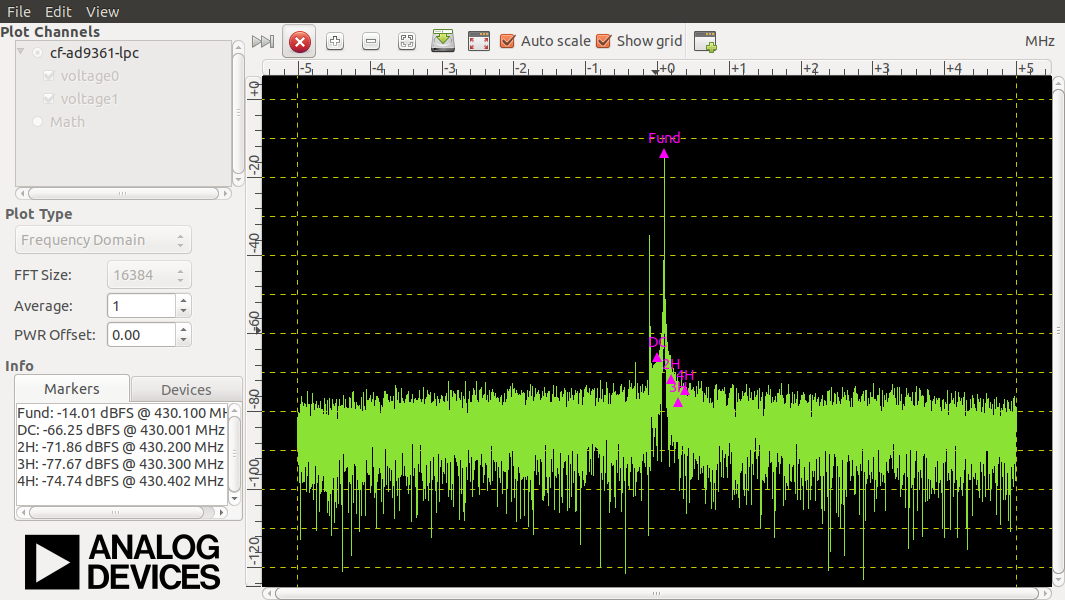

In [31]:
display(Image('rx_recording_capture.png', width=800, height=800))

In [32]:
# to see a clean signal from data, create one that fits exactly into the sample array
def fitCycles(cycles, length, complex=False):
    xx = np.arange(length)
    arg = 2*np.pi*xx*cycles/length
    if complex:
        return np.cos(arg) + 1j*np.sin(arg)
    else:
        return np.sin(arg)


iq = fitCycles(400, 0x4000, True)*0.5     # scale to 0.5 to prevent overload of DAC


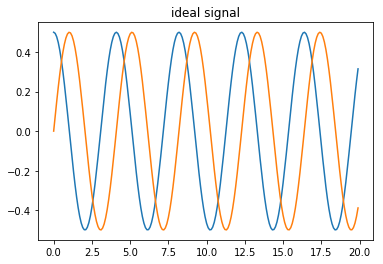

In [33]:
plt.title('ideal signal')
plt.plot(time[zoom], iq.real[zoom], time[zoom], iq.imag[zoom])

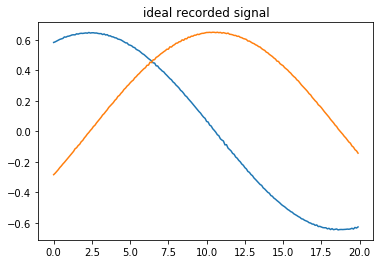

In [34]:
# adjust tx and rx gain to avoid distortion
sdr.rx_gain_mode = 'manual'
sdr.rx_gain = 30
sdr.tx_gain = -30
sdr.writeTx(iq)    # seems to require further attenuation to approach FS?
                       # need to also set the Tx attenuation param  
ideal_data = sdr.readRx(0x4000, raw=False)
plt.plt.title('ideal recorded signal')
plt.plot(time[zoom], ideal_data.real[zoom], time[zoom], ideal_data.imag[zoom])

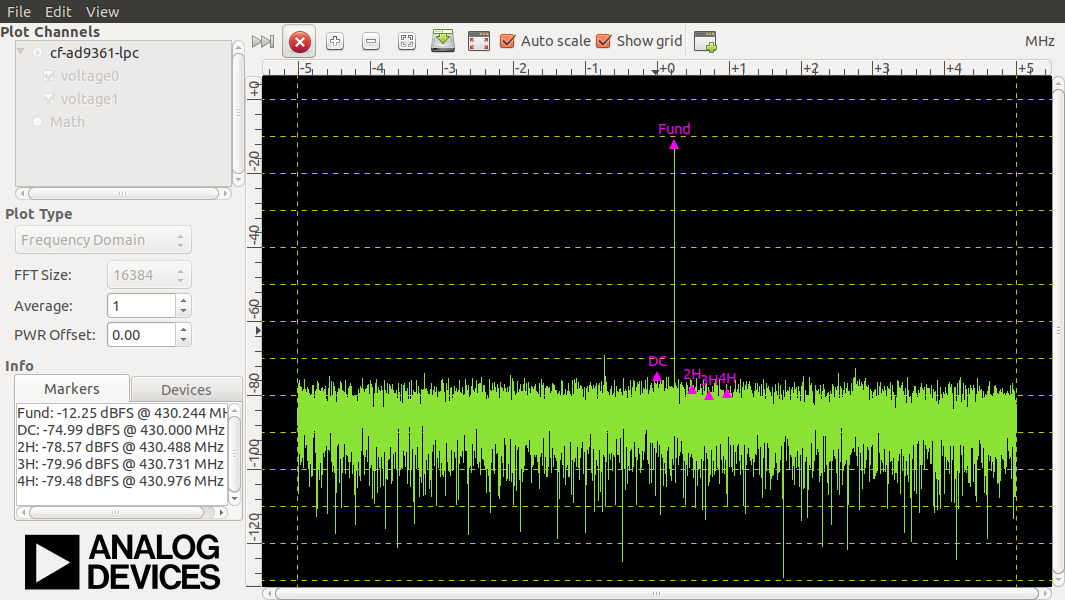

In [35]:
# this is captured via the loopback cable using from iio_scope
# the levels may be different when run on another platform
display(Image('ideal_recording_capture.png', width=800, height=800))

In [38]:
sdr.txStatus()

Tx Fs: 10.0MHz	BB:    1.25MHz
   BW: 18.0MHz	LO:  430.00MHz
 Gain:-30.0dB	State: dma
 Data:8192


In [37]:
sdr.rxStatus()

Rx Fs:10.0MHz	BB:   10.00MHz
   BW:18.0MHz	LO:  430.00MHz
 Gain:30.0dB	Mode: manual
